Librerias 

In [5]:
import nltk
from nltk.corpus import wordnet as wn
import networkx as nx
import matplotlib.pyplot as plt

Datos 

In [6]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ENRIQUE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ENRIQUE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Traducimos las palbras para tenerlo en una sola lengua 

In [7]:
def traducir(palabra, lang_src='eng', lang_tgt='spa'):
    """Traduce una palabra usando Open Multilingual WordNet ."""
    resultados = []
    for synset in wn.synsets(palabra, lang=lang_src):
        traducciones = [t.name() for t in synset.lemmas(lang_tgt)]
        if traducciones:
            resultados.extend(traducciones)
    return list(set(resultados))

def traducir_lista(lista_palabras, lang_src='eng', lang_tgt='spa'):
    """Traduce listas de palabras."""
    traducidas = []
    for palabra in lista_palabras:
        t = traducir(palabra, lang_src, lang_tgt)
        traducidas.append(t[0] if t else palabra)
    return traducidas

def elegir_traduccion_relevante(palabra, synset, idioma_origen='eng', idioma_destino='spa'):
    """
    Selecciona la traducción más coherente con la definición del synset.
    Si hay ambigüedad, mantiene la palabra original.
    """
    traducciones = traducir(palabra, idioma_origen, idioma_destino)
    if not traducciones:
        return palabra  # si no hay traducción, usar original

    definicion = synset.definition().lower()
    # Heurística: buscar si alguna traducción comparte raíz o tema con la definición
    for t in traducciones:
        if t.lower() in definicion or t.lower().startswith(palabra[:4].lower()):
            return t

    # Si no hay coincidencia, elegir la más frecuente en español
    preferidas = [
        "computadora", "ordenador", "educación", "lenguaje", "amor",
        "psicología", "lingüística", "persona", "animal", "árbol",
        "ciudad", "música", "arte", "vida", "trabajo", "sociedad"
    ]
    for pref in preferidas:
        if pref in traducciones:
            return pref

    # Si ninguna coincide, mantener original (Por que tuve un problema con cpmputadora, ya que la traduccion la estaba tomando mal o como otro nodo)
    return palabra

In [12]:
def crear_red_semantica(palabra, idioma='eng'):
    """
    Crea y visualiza una red semántica de una palabra usando WordNet.
    idioma: 'eng' o 'spa'
    """
    #  Obtener synset principal
    synsets = wn.synsets(palabra, lang=idioma)
    if not synsets:
        print(f" No se encontró '{palabra}' en WordNet ({idioma}).")
        return
    s = synsets[0]

    print(f"\n Synset seleccionado: {s.name()}")
    print("Definición:", s.definition())

    #  Extraer relaciones léxicas
    sinonimos = [lemma.name() for lemma in s.lemmas()]
    antonimos = [ant.name() for lemma in s.lemmas() for ant in lemma.antonyms()]
    hiperonimos = [h.name().split('.')[0] for h in s.hypernyms()]
    hiponimos = [h.name().split('.')[0] for h in s.hyponyms()]
    meronimos = [m.name().split('.')[0] for m in s.part_meronyms()]
    holonimos = [h.name().split('.')[0] for h in s.member_holonyms()]

    print("\n Relaciones encontradas:")
    print("  Sinonimia:", sinonimos)
    print("  Hiperonimia:", hiperonimos)
    print("  Hiponimia:", hiponimos[:5])
    print("  Meronimia:", meronimos)
    print("  Holonimia:", holonimos)

    #  Si es inglés → traducir todo al español
    if idioma == 'eng':
        sinonimos = traducir_lista(sinonimos)
        hiperonimos = traducir_lista(hiperonimos)
        hiponimos = traducir_lista(hiponimos)
        meronimos = traducir_lista(meronimos)
        holonimos = traducir_lista(holonimos)
        palabra_central = elegir_traduccion_relevante(palabra, s)
    else:
        palabra_central = palabra.capitalize()

    #  Construir el grafo
    G = nx.Graph()
    G.add_node(palabra_central)

    relaciones = {
        "sinonimia": sinonimos or ["(sin datos)"],
        "hiperonimia": hiperonimos or ["(sin datos)"],
        "hiponimia": hiponimos or ["(sin datos)"],
        "meronimia": meronimos or ["(sin datos)"],
        "holonimia": holonimos or ["(sin datos)"]
    }

    for tipo, palabras in relaciones.items():
        for p in palabras:
            G.add_edge(palabra_central, p, tipo=tipo)

    #  Colores por tipo de relación
    colores = {
        "sinonimia": "lightgreen",
        "hiperonimia": "violet",
        "hiponimia": "orange",
        "meronimia": "skyblue",
        "holonimia": "lightcoral"
    }
    edge_colors = [colores[G[u][v]['tipo']] for u, v in G.edges()]

    #  Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.6, iterations=40)
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="white", edgecolors="black")
    nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, font_size=11, font_family="DejaVu Sans", font_weight="bold")

    # Leyenda
    for tipo, color in colores.items():
        plt.scatter([], [], color=color, label=tipo.capitalize())
    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc="best")

    plt.title(f" Red semántica del término '{palabra_central}' (WordNet - {idioma})")
    plt.axis("off")
    plt.show()



 Synset seleccionado: machine.n.01
Definición: any mechanical or electrical device that transmits or modifies energy to perform or assist in the performance of human tasks

 Relaciones encontradas:
  Sinonimia: ['machine']
  Hiperonimia: ['device']
  Hiponimia: ['perpetual_motion_machine', 'machinery', 'calculator', 'farm_machine', 'concrete_mixer']
  Meronimia: []
  Holonimia: []


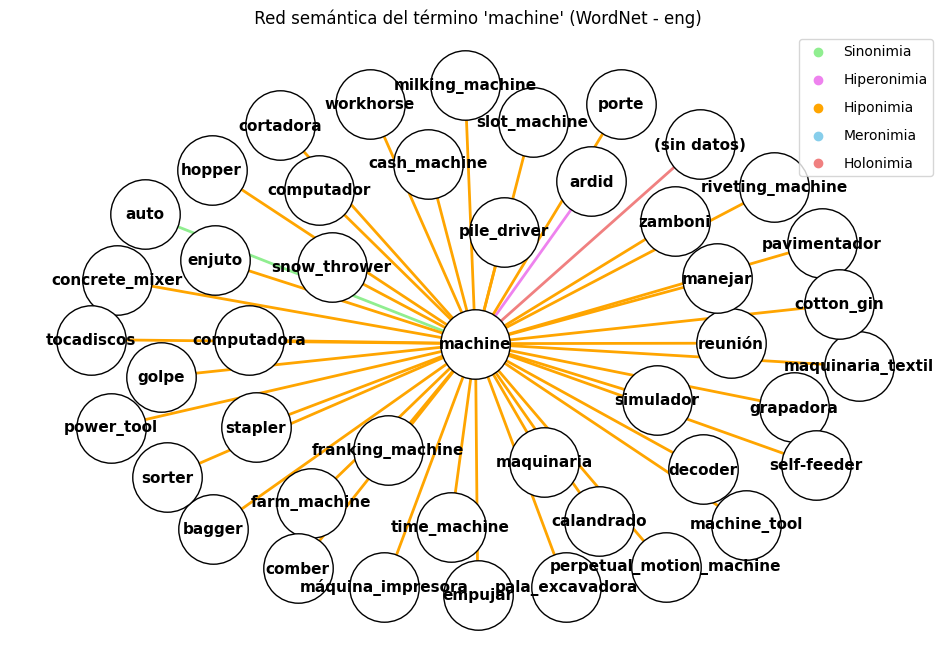

In [15]:
crear_red_semantica("machine")